In [3]:
import sys, platform, os
import pickle
import tqdm
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))
# Initial setup:
number_of_samples = 10
LCDM_priors = {
               'omegabh2': [0.022, 0.022],
               'omegach2': [0.122, 0.122],
               'H0': [67.5, 67.5],
               'ns': [0.8, 1.2],
               'logAs': [2, 2],
               }
redshifts= np.linspace(3, 0, 20)
#definisco il file dove caricherò le sigma a ogni presa dati
cache_file = './LCDM_sigma6_8.cache' 

Using CAMB 1.3.5 installed at C:\Users\lenovo\anaconda3\lib\site-packages\camb


In [4]:
# if the cache file exists load it and append, otherwise initialize as empty:
#è proprio la definizione di un file specifico a partire da uno generico in camb
if os.path.isfile(cache_file):
    #leggo converto e carico
    #pickle converte le sigma che calcolerò che sono in samples in una lista di bite le carica con load avendole lette con open rb read binary
    sigma_8_samples = list(pickle.load(open(cache_file, 'rb')))
else:
    sigma_8_samples = []

# start the loop:
for i in tqdm.tqdm(range(number_of_samples)):
    # generate the sample:
    #mi dice cosa ci sta nel numero di samples, ovvero un loop che a ogni giro prende gli elementi delle prior
    #questi elementi devono essere generati casualmente uno per uno, da cui 1 come size. i primi due termini in parentesi sono richiamano nell'ordine di lista per ciascumo estremo inferiore e superiore
    _omegabh2 = np.random.uniform(LCDM_priors['omegabh2'][0], LCDM_priors['omegabh2'][1], 1)[0]
    _omegach2 = np.random.uniform(LCDM_priors['omegach2'][0], LCDM_priors['omegach2'][1], 1)[0]
    _H0 = np.random.uniform(LCDM_priors['H0'][0], LCDM_priors['H0'][1], 1)[0]
    _ns = np.random.uniform(LCDM_priors['ns'][0], LCDM_priors['ns'][1], 1)[0]
    _logAs = np.random.uniform(LCDM_priors['logAs'][0], LCDM_priors['logAs'][1], 1)[0]
    # process parameters to feed to CAMB:
    _As = 10**(-10)*np.exp(_logAs)
    # set up camb:
    pars = camb.set_params(H0=_H0, ombh2=_omegabh2, omch2=_omegach2, As=_As, ns=_ns)
    pars.set_matter_power(redshifts, kmax=2.0)
    pars.NonLinear = model.NonLinear_none
    # call camb and compute cosmology:
    results = camb.get_results(pars)
    # get sigma8:
    sigma8_z = np.array(results.get_sigma8())
    # append to samples:
    sigma_8_samples.append(results.get_sigma8().copy())
    
# convert to numpy array:
sigma_8_samples = np.array(sigma_8_samples)

# save out to file:
#oltre al caricare devo salvare i dati wb write binary il file è già scritto in binario così phyton non altera i dati
pickle.dump(sigma_8_samples, open(cache_file, 'wb'))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:22<00:00,  2.20s/it]


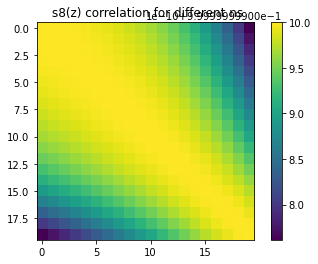

In [5]:
# plot correlation matrix:
plt.title(' s8(z) correlation for different ns')

#fissarescalacolori
sigma8_corr = np.corrcoef(sigma_8_samples.T)
plt.imshow(sigma8_corr)
plt.colorbar()
plt.show()

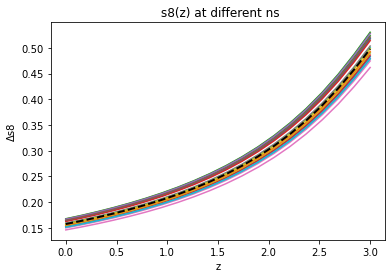

In [6]:
# plot some samples:
#grafico 20 samples e la media delle sigma
mean = np.mean(sigma_8_samples, axis=0)
#perchè 20 samples e non10/ così funziona per almeno due avvii(prob perchè ho 20 redshift)
samples_to_plot = 20
plt.plot(redshifts[::-1], mean, color='k', ls='--', lw=2., zorder=999)
for i in range(samples_to_plot):
    _ind = int(i * np.floor(sigma_8_samples.shape[0]/samples_to_plot))
    plt.plot(redshifts[::-1], sigma_8_samples[_ind, :])
    plt.title(' s8(z) at different ns')
plt.xlabel('z');
plt.ylabel('Δs8');

In [13]:
#calcolo sigma per il minimo z
pars = camb.set_params(H0=_H0, ombh2=_omegabh2, omch2=_omegach2, As=_As, ns=_ns)
pars.set_matter_power([0.0], kmax=2.0)
results = camb.get_results(pars)
print(results.get_sigma8())

[0.4865607]


In [14]:
#calcolo sigma per il massimo z
pars = camb.set_params(H0=_H0, ombh2=_omegabh2, omch2=_omegach2, As=_As, ns=_ns)
pars.set_matter_power([3.0], kmax=2.0)
results = camb.get_results(pars)

print(results.get_sigma8())

[0.15369205]
